In [35]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# --- Function to Optimize: 2D Rastrigin ---
def rastrigin(x, y):
    """
    Calculates the value of the 2D Rastrigin function.
    Global minimum is f(0, 0) = 0.
    """
    return 20 + x**2 + y**2 - 10 * (np.cos(2 * np.pi * x) + np.cos(2 * np.pi * y))

# --- Problem Domain ---
BOUNDS = np.array([-5.12, 5.12])

In [36]:
def run_ga(fitness_func, bounds, pop_size=100, n_gen=200, pc=0.8, pm=0.1, eta_c=1, eta_m=20):
    """
    Raw Implemntation of Genetic Algorithm.
    """
    # --- 1. Initialization ---
    population = np.random.uniform(bounds[0], bounds[1], (pop_size, 2))
    convergence_history = []

    for gen in range(n_gen):
        # --- 2. Fitness Evaluation ---
        fitness_scores = np.array([fitness_func(ind[0], ind[1]) for ind in population])
        best_idx = np.argmin(fitness_scores)
        best_fitness = fitness_scores[best_idx]
        convergence_history.append(best_fitness)

        # --- 3. Selection (Tournament) ---
        selected_parents = []
        for _ in range(pop_size):
            p1_idx, p2_idx = np.random.randint(0, pop_size, 2)
            if fitness_scores[p1_idx] < fitness_scores[p2_idx]:
                selected_parents.append(population[p1_idx])
            else:
                selected_parents.append(population[p2_idx])
        parents = np.array(selected_parents)

        # --- 4. Crossover (Simulated Binary Crossover) ---
        children = np.zeros((pop_size, 2))
        for i in range(0, pop_size, 2):
            p1, p2 = parents[i], parents[i+1]
            if np.random.rand() < pc:
                for j in range(2): # For each dimension (x, y)
                    u = np.random.rand()
                    if u <= 0.5:
                        beta = (2 * u)**(1 / (eta_c + 1))
                    else:
                        beta = (1 / (2 * (1 - u)))**(1 / (eta_c + 1))
                    children[i, j] = 0.5 * ((1 + beta) * p1[j] + (1 - beta) * p2[j])
                    children[i+1, j] = 0.5 * ((1 - beta) * p1[j] + (1 + beta) * p2[j])
            else:
                children[i], children[i+1] = p1, p2

        # --- 5. Mutation (Polynomial Mutation) ---
        for i in range(pop_size):
            if np.random.rand() < pm:
                for j in range(2): # For each dimension (x, y)
                    u = np.random.rand()
                    delta_q = 0
                    if u < 0.5:
                        delta_q = (2 * u)**(1 / (eta_m + 1)) - 1
                    else:
                        delta_q = 1 - (2 * (1 - u))**(1 / (eta_m + 1))
                    mutated_gene = children[i, j] + delta_q * (bounds[1] - bounds[0])
                    mutated_gene = np.clip(mutated_gene, bounds[0], bounds[1])
                    children[i, j] = mutated_gene
        population = children

    final_fitness = np.array([fitness_func(ind[0], ind[1]) for ind in population])
    best_solution = population[np.argmin(final_fitness)]
    best_fitness = np.min(final_fitness)

    return best_solution, best_fitness, convergence_history

In [37]:
def run_de(fitness_func, bounds, pop_size=100, n_gen=200, F=0.8, CR=0.9):
    """
    Raw Implemntation of Differential Evolution algorithm.
    """
    # --- 1. Initialization ---
    population = np.random.uniform(bounds[0], bounds[1], (pop_size, 2))
    convergence_history = []

    for gen in range(n_gen):
        fitness_scores = np.array([fitness_func(ind[0], ind[1]) for ind in population])
        best_fitness = np.min(fitness_scores)
        convergence_history.append(best_fitness)

        for i in range(pop_size):
            # --- 2. Mutation ---
            idxs = [idx for idx in range(pop_size) if idx != i]
            r1, r2, r3 = population[np.random.choice(idxs, 3, replace=False)]
            mutant_vector = r1 + F * (r2 - r3)
            mutant_vector = np.clip(mutant_vector, bounds[0], bounds[1])

            # --- 3. Crossover (Binomial) ---
            trial_vector = np.zeros(2)
            j_rand = np.random.randint(0, 2)
            for j in range(2):
                if np.random.rand() < CR or j == j_rand:
                    trial_vector[j] = mutant_vector[j]
                else:
                    trial_vector[j] = population[i, j]

            # --- 4. Selection ---
            trial_fitness = fitness_func(trial_vector[0], trial_vector[1])
            current_fitness = fitness_func(population[i, 0], population[i, 1])

            if trial_fitness < current_fitness:
                population[i] = trial_vector

    final_fitness = np.array([fitness_func(ind[0], ind[1]) for ind in population])
    best_solution = population[np.argmin(final_fitness)]
    best_fitness = np.min(final_fitness)

    return best_solution, best_fitness, convergence_history

In [38]:
def run_pso(fitness_func, bounds, n_particles=100, n_iter=200, w_max=0.9, w_min=0.4, c1=1.5, c2=1.5):
    """
    Raw Implemntation of Particle Swarm Optimization algorithm.
    """
    # --- 1. Initialization ---
    positions = np.random.uniform(bounds[0], bounds[1], (n_particles, 2))
    velocities = np.random.uniform(-1, 1, (n_particles, 2))
    pbest_positions = positions.copy()
    pbest_scores = np.array([fitness_func(p[0], p[1]) for p in positions])

    gbest_idx = np.argmin(pbest_scores)
    gbest_position = pbest_positions[gbest_idx].copy()
    gbest_score = pbest_scores[gbest_idx]

    convergence_history = []

    for t in range(n_iter):
        convergence_history.append(gbest_score)
        w = w_max - (w_max - w_min) * t / n_iter

        for i in range(n_particles):
            # --- 2. Update Velocity ---
            r1, r2 = np.random.rand(2)
            cognitive_velocity = c1 * r1 * (pbest_positions[i] - positions[i])
            social_velocity = c2 * r2 * (gbest_position - positions[i])
            velocities[i] = w * velocities[i] + cognitive_velocity + social_velocity

            # --- 3. Update Position ---
            positions[i] = positions[i] + velocities[i]
            positions[i] = np.clip(positions[i], bounds[0], bounds[1])

            # --- 4. Update Personal and Global Best ---
            current_score = fitness_func(positions[i, 0], positions[i, 1])
            if current_score < pbest_scores[i]:
                pbest_scores[i] = current_score
                pbest_positions[i] = positions[i].copy()
            if current_score < gbest_score:
                gbest_score = current_score
                gbest_position = positions[i].copy()

    return gbest_position, gbest_score, convergence_history

Running Genetic Algorithm...
GA Best Solution: [1.24076590e-09 9.94958637e-01], Fitness: 0.994959

Running Differential Evolution...
DE Best Solution: [1.54022051e-09 1.85511688e-09], Fitness: 0.000000

Running Particle Swarm Optimization...
PSO Best Solution: [ 5.07471286e-10 -1.32704808e-09], Fitness: 0.000000

Saving convergence data to CSV files...
...Done.


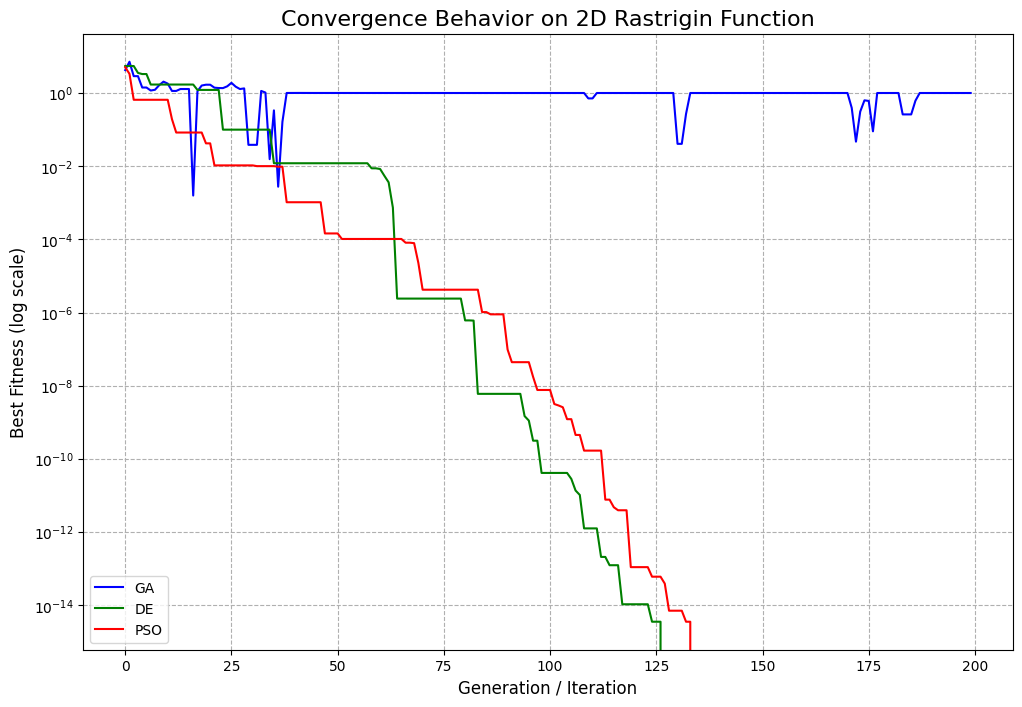

In [39]:
POP_SIZE = 100
GENERATIONS = 200
np.random.seed(42) # for reproducibility

# --- Run Optimizers ---
print("Running Genetic Algorithm...")
ga_solution, ga_fitness, ga_history = run_ga(rastrigin, BOUNDS, pop_size=POP_SIZE, n_gen=GENERATIONS)
print(f"GA Best Solution: {ga_solution}, Fitness: {ga_fitness:.6f}\n")

print("Running Differential Evolution...")
de_solution, de_fitness, de_history = run_de(rastrigin, BOUNDS, pop_size=POP_SIZE, n_gen=GENERATIONS)
print(f"DE Best Solution: {de_solution}, Fitness: {de_fitness:.6f}\n")

print("Running Particle Swarm Optimization...")
pso_solution, pso_fitness, pso_history = run_pso(rastrigin, BOUNDS, n_particles=POP_SIZE, n_iter=GENERATIONS)
print(f"PSO Best Solution: {pso_solution}, Fitness: {pso_fitness:.6f}\n")

print("Saving convergence data to CSV files...")
ga_df = pd.DataFrame({'Generation': range(1, len(ga_history) + 1), 'Best_Fitness': ga_history})
ga_df.to_csv('ga_convergence.csv', index=False)

de_df = pd.DataFrame({'Generation': range(1, len(de_history) + 1), 'Best_Fitness': de_history})
de_df.to_csv('de_convergence.csv', index=False)

pso_df = pd.DataFrame({'Generation': range(1, len(pso_history) + 1), 'Best_Fitness': pso_history})
pso_df.to_csv('pso_convergence.csv', index=False)
print("...Done.")


# --- Plotting Convergence ---
plt.figure(figsize=(12, 8))
plt.plot(ga_history, label='GA', color='blue')
plt.plot(de_history, label='DE', color='green')
plt.plot(pso_history, label='PSO', color='red')
plt.title('Convergence Behavior on 2D Rastrigin Function', fontsize=16)
plt.xlabel('Generation / Iteration', fontsize=12)
plt.ylabel('Best Fitness (log scale)', fontsize=12)
plt.yscale('log')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()

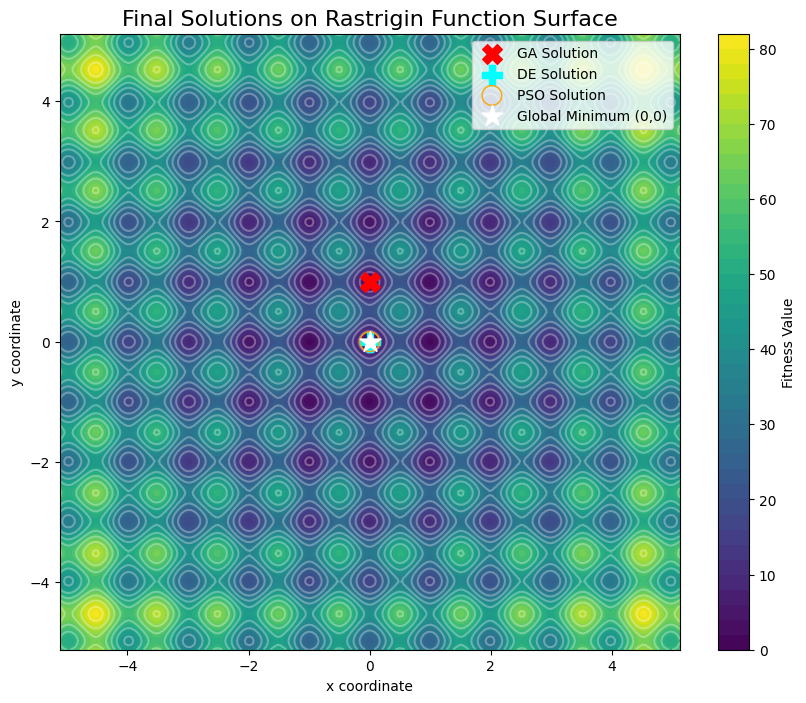

In [40]:
# --- Create a grid of points to plot the function's surface ---
x_plot = np.linspace(BOUNDS[0], BOUNDS[1], 200)
y_plot = np.linspace(BOUNDS[0], BOUNDS[1], 200)
X, Y = np.meshgrid(x_plot, y_plot)
Z = rastrigin(X, Y)

# --- Create the Contour Plot ---
plt.figure(figsize=(10, 8))
# Plot the filled contour (heatmap)
cp = plt.contourf(X, Y, Z, levels=50, cmap='viridis')
# Plot the contour lines
plt.contour(X, Y, Z, levels=15, colors='white', alpha=0.3)
plt.colorbar(cp, label='Fitness Value')

# --- Plot the solutions found by the optimizers ---
# GA Solution
plt.scatter(ga_solution[0], ga_solution[1], marker='X', color='red', s=200, label=f'GA Solution', zorder=3)
# DE Solution
plt.scatter(de_solution[0], de_solution[1], marker='P', color='cyan', s=200, label=f'DE Solution', zorder=3)
# PSO Solution
plt.scatter(pso_solution[0], pso_solution[1], marker='o', facecolors='none', edgecolors='orange', s=200, label=f'PSO Solution', zorder=3)
# Global Minimum (for reference)
plt.scatter(0, 0, marker='*', color='white', s=250, label='Global Minimum (0,0)', zorder=3)


# --- Final Plot Details ---
plt.title('Final Solutions on Rastrigin Function Surface', fontsize=16)
plt.xlabel('x coordinate')
plt.ylabel('y coordinate')
plt.legend(loc='upper right')
plt.show()